<a href="https://colab.research.google.com/github/shivani-nandani/emotion-detection/blob/main/jaffe_pca_svm_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

reference - [https://radiant-brushlands-42789.herokuapp.com/towardsdatascience.com/building-a-facial-recognition-model-using-pca-svm-algorithms-c81d870add16](https://radiant-brushlands-42789.herokuapp.com/towardsdatascience.com/building-a-facial-recognition-model-using-pca-svm-algorithms-c81d870add16)

In [1]:
import pylab as pl
import numpy as np
import os
import cv2
from matplotlib import pyplot as plt
import matplotlib.image as mplib 
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA as RandomizedPCA
from sklearn.svm import SVC

In [8]:
img_data_list=[]
label_dict = {'AN': 0, 'DI': 1, 'FE': 2, 'HA': 3, 'NE': 4, 'SA': 5, 'SU': 6}
labels = []
directory = '/content/drive/MyDrive/JAFFE'

for img in os.listdir(directory):
    input_img = cv2.imread(directory+'/'+img)
    input_img = cv2.cvtColor(input_img, cv2.COLOR_BGR2GRAY)
    img_data_list.append(input_img)
    labels.append(label_dict[img.split('.')[1][:2]])
        
img_data = np.array(img_data_list)
img_data = img_data.astype('float32')
img_data = img_data/255

n_samples, h, w = img_data.shape
np.random.seed(42)

img_data = img_data.reshape(n_samples,-1)
labels = np.array(labels)

names = ['anger','disgust','fear','happy','neutral','sadness','surprise']

num_classes = len(names)

def getLabel(id):
    return ['anger','disgust','fear','happy','neutral','sadness','surprise'][id]

img_data.shape, labels.shape

((213, 65536), (213,))

In [9]:
Y = np_utils.to_categorical(labels, num_classes)
y = labels
X_train, X_test, y_train, y_test = train_test_split(img_data, y, test_size=0.30, shuffle=True, random_state=42)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((149, 65536), (149,), (64, 65536), (64,))

In [117]:
n_components = 130
pca = RandomizedPCA(n_components=n_components, whiten=True).fit(X_train)
sum(pca.explained_variance_ratio_)

0.9942515087604988

In [118]:
eigenfaces = pca.components_.reshape((n_components, h, w))
eigenfaces.shape

(130, 256, 256)

In [119]:
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
X_train_pca.shape, X_test_pca.shape

((149, 130), (64, 130))

In [120]:
print("Fitting the classifier to the training set")
param_grid = {
    'C': [1e3, 5e3, 1e4, 5e4, 1e5],
    'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1],
}
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'),
param_grid)
clf = clf.fit(X_train_pca, y_train)
print("Best estimator found by grid search:")
print(clf.best_estimator_)

Fitting the classifier to the training set
Best estimator found by grid search:
SVC(C=1000.0, break_ties=False, cache_size=200, class_weight='balanced',
    coef0=0.0, decision_function_shape='ovr', degree=3, gamma=0.0001,
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)


In [121]:
print("Predicting the people names on the testing set")
y_pred = clf.predict(X_test_pca)

Predicting the people names on the testing set


In [122]:
print(classification_report(y_test, y_pred, target_names=names))

              precision    recall  f1-score   support

       anger       0.92      0.92      0.92        12
     disgust       0.90      1.00      0.95         9
        fear       0.50      1.00      0.67         4
       happy       1.00      0.55      0.71        11
     neutral       0.70      1.00      0.82         7
     sadness       0.90      0.75      0.82        12
    surprise       1.00      0.89      0.94         9

    accuracy                           0.84        64
   macro avg       0.85      0.87      0.83        64
weighted avg       0.89      0.84      0.84        64



In [123]:
print(confusion_matrix(y_test, y_pred, labels=range(num_classes)))

[[11  1  0  0  0  0  0]
 [ 0  9  0  0  0  0  0]
 [ 0  0  4  0  0  0  0]
 [ 0  0  2  6  2  1  0]
 [ 0  0  0  0  7  0  0]
 [ 1  0  1  0  1  9  0]
 [ 0  0  1  0  0  0  8]]


In [124]:
def title(y_pred, y_test, target_names, i):
    pred_name = names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = names[y_test[i]].rsplit(' ', 1)[-1]
    return 'predicted: %s\ntrue: %s' % (pred_name, true_name)

def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

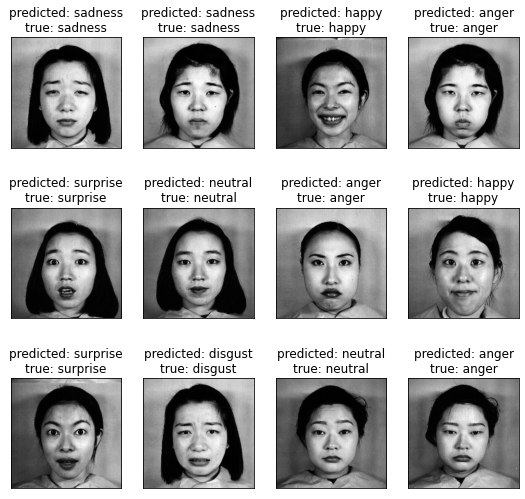

In [125]:
prediction_titles = [title(y_pred, y_test, names, i) for i in range(y_pred.shape[0])]
plot_gallery(X_test, prediction_titles, h, w)

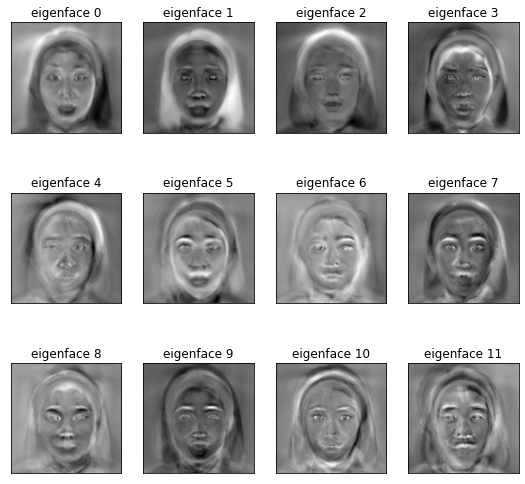

In [126]:
eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)
plt.show()

In [127]:
from sklearn.metrics import accuracy_score
score = accuracy_score(y_test, y_pred)
print(score)

0.84375


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# EXPERIMENTS

In [ ]:
import torch
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split

from torch.utils.data import Dataset, DataLoader
import os
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [ ]:
label_dict = {'AN': 0, 'DI': 1, 'FE': 2, 'HA': 3, 'NE': 4, 'SA': 5, 'SU': 6}
labels = []
img_data = []

for img_path in os.listdir('/content/drive/MyDrive/JAFFE'):
    img = Image.open(img_path)
    rgbimg = Image.new("RGBA", img.size)
    rgbimg.paste(img)
    rgbimg = rgbimg.convert('RGB')
    img_data.append(rgbimg)
    labels.append(label_dict[img_path.split('.')[1][:2]])

labels = np.array(labels)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(img_data, labels, test_size=0.30, shuffle=True, random_state=42)
y_train.shape, y_test.shape

((149,), (64,))

In [ ]:
torch.hub._validate_not_a_forked_repo=lambda a,b,c: True
model = torch.hub.load('pytorch/vision:v0.9.0', 'resnet18', pretrained=True)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.9.0


In [ ]:
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
input_tensor = preprocess(img_data[0])
input_batch = input_tensor.unsqueeze(0)

In [ ]:
train_data = torch.zeros((149,3,224,224))
train_labels = torch.zeros((149,1))
for i in range(len(X_train)):
  train_data[i] = preprocess(X_train[i])
  train_labels[i] = y_train[i]
train_data = model(train_data)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [ ]:
class Network(nn.Module):
    
    def __init__(self):
        super(Network, self).__init__()
        self.l1 = nn.Linear(1000, 500)
        self.relu = nn.ReLU()
        self.l2 = nn.Linear(500, 100)
        self.l3 = nn.Linear(100,7)
        
    def forward(self, x):
        x = self.l1(x)
        x = self.relu(x)
        x = self.l2(x)
        x = self.relu(x)
        x = self.l3(x)
        return F.log_softmax(x)

In [ ]:
net = Network()

In [ ]:
optimizer = optim.SGD(net.parameters(), lr=1e-4, momentum=0.9)
loss_func = nn.CrossEntropyLoss()

In [ ]:
for e in range(500):
    net_out = net(train_data)
    loss = loss_func(net_out, train_labels.squeeze(1).type(torch.LongTensor))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  app.launch_new_instance()


RuntimeError: ignored